In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow_tts.processor.ljspeech import LJSpeechProcessor
from tensorflow_tts.processor.ljspeech import symbols

from tensorflow_tts.configs import Tacotron2Config
from tensorflow_tts.models import TFTacotron2

import IPython.display as ipd

In [2]:
with open('./conf/tacotron2.v1.yaml') as f:
    config = yaml.load(f, Loader=yaml.Loader)

In [3]:
config = Tacotron2Config(**config["tacotron2_params"])

In [4]:
tacotron2 = TFTacotron2(config=config, training=False, name="tacotron2")

In [5]:
tacotron2._build()

In [6]:
tacotron2.summary()

Model: "tacotron2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (TFTacotronEncoder)  multiple                  8218624   
_________________________________________________________________
decoder_cell (TFTacotronDeco multiple                  18994184  
_________________________________________________________________
post_net (TFTacotronPostnet) multiple                  5460480   
_________________________________________________________________
residual_projection (Dense)  multiple                  41040     
Total params: 32,714,328
Trainable params: 32,704,088
Non-trainable params: 10,240
_________________________________________________________________


In [7]:
tacotron2.load_weights("./pretrained/tacotron2.v1-45000.h5")

In [8]:
input_text = "Recent research at Harvard has shown meditating \
              for as little as 8 weeks can actually increase the \
              grey matter in the parts of the brain responsible for \
              emotional regulation and learning."

In [9]:
input_ids = LJSpeechProcessor(None, None).text_to_sequence(input_text, ["english_cleaners"])
input_ids = np.concatenate([input_ids, [len(symbols) - 1]], -1)

In [32]:
decoder_output, mel_outputs, stop_token_prediction, alignment_history = tacotron2.inference(
    input_ids=np.expand_dims(input_ids, 0),
    input_lengths=np.array([len(input_ids)]),
    speaker_ids=np.array([0]),
    use_window_mask=True,
    win_front=3,
    win_back=3
)

In [33]:
# remove padding at tail of mels (padding value on training is -6.0)
# a mel is normailzed with mean and variance so it's safe if we remove
# all mel frame have value < - (max_val_mel + 1). +1 is just for safe
sequence_mask = tf.reduce_all(mel_outputs >= -(tf.reduce_max(mel_outputs) + 1), -1)
real_length = tf.math.reduce_sum(tf.cast(sequence_mask, tf.int32), -1)
mel_outputs = mel_outputs[:, :real_length[0], :]

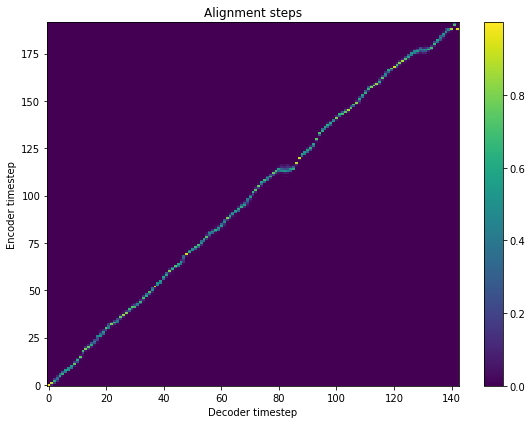

In [34]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title(f'Alignment steps')
im = ax.imshow(
    alignment_history[0].numpy(),
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()
plt.close()

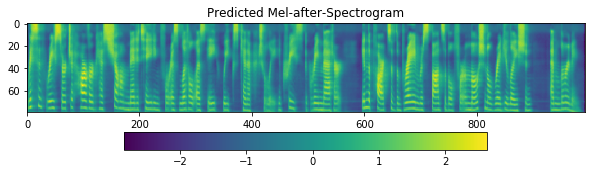

In [35]:
mel_outputs = tf.reshape(mel_outputs, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

MELGAN VOCODER

In [36]:
from tensorflow_tts.models import TFMelGANGenerator
from tensorflow_tts.configs import MelGANGeneratorConfig

In [ ]:
config = MelGANGeneratorConfig()
melgan = TFMelGANGenerator(config=config, name='melgan_generator')
melgan(np.expand_dims(mel_outputs, 0))  # build model.

In [ ]:
melgan.load_weights('./pretrained/melgan.v1-2160000.h5')

In [ ]:
melgan = tf.function(melgan, 
                     experimental_relax_shapes=True, 
                     input_signature=[tf.TensorSpec(shape=[None, None, 80], dtype=tf.float32)])

In [ ]:
audio_pred = melgan(np.expand_dims(mel_outputs * 1.3, 0))[0, :, 0].numpy()

In [ ]:
ipd.Audio(audio_pred, rate=22050)

In [ ]:
plt.plot(audio_pred)